In [1]:
import os
import glob
import random
import numpy as np
import cv2

import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras import layers
from tensorflow.keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from tensorflow.keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications.imagenet_utils import preprocess_input

from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, confusion_matrix

import pydot
from IPython.display import SVG
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
%matplotlib inline

### Load and Split Dataset

In [2]:
# Get the path to the parent directory
parent_dir = os.path.dirname(os.getcwd())

# List files in the parent directory
files_in_parent = os.listdir(os.getcwd())
print("Files in curr Directory:", files_in_parent)
print("Files in Parent Directory:", files_in_parent)

Files in curr Directory: ['.ipynb_checkpoints', 'aug-data', 'gender-data', 'gender-model.keras', 'gender-model.weights.h5', 'OCR-gender-baseLine-model.html', 'OCR-gender-baseLine-model.ipynb', 'OCR-gender-model-test.ipynb', 'test-data']
Files in Parent Directory: ['.ipynb_checkpoints', 'aug-data', 'gender-data', 'gender-model.keras', 'gender-model.weights.h5', 'OCR-gender-baseLine-model.html', 'OCR-gender-baseLine-model.ipynb', 'OCR-gender-model-test.ipynb', 'test-data']


In [3]:
# Define folder paths
male_path = "gender-data\\male"
female_path = "gender-data\\female"
augmented_data_path = "aug-data\\"

# Lists for images and labels
images = []
labels = []

def load_images_from_folder(folder_path, label):
    for filename in os.listdir(folder_path):
        if filename.endswith(('.jpg', '.png')):  # Check for multiple image formats
            img_path = os.path.join(folder_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))
                images.append(img)
                labels.append(label)

# Load images
load_images_from_folder(male_path, 0)      
load_images_from_folder(female_path, 1)    
load_images_from_folder(augmented_data_path, 1)  

# Convert to numpy arrays
images = np.array(images)
labels = np.array(labels)

# Split the dataset into training and validation sets
train_images, val_images, train_labels, val_labels = train_test_split(
    images, labels, test_size=0.3, stratify=labels, random_state=42
)

# Print shapes of the training and validation sets
print("Training images shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Validation images shape:", val_images.shape)
print("Validation labels shape:", val_labels.shape)


Training images shape: (701, 224, 224, 3)
Training labels shape: (701,)
Validation images shape: (301, 224, 224, 3)
Validation labels shape: (301,)


### Calculate classes ratios

In [4]:
# Calculate the percentage of each class in the training dataset
unique_train_labels, train_counts = np.unique(train_labels, return_counts=True)
train_percentages = train_counts / len(train_labels) * 100

# Calculate the percentage of each class in the validation dataset
unique_val_labels, val_counts = np.unique(val_labels, return_counts=True)
val_percentages = val_counts / len(val_labels) * 100

# Display the class distribution
for label, percentage in zip(unique_train_labels, train_percentages):
    print(f"Training Class {label}: {percentage:.2f}%")

for label, percentage in zip(unique_val_labels, val_percentages):
    print(f"Validation Class {label}: {percentage:.2f}%")


Training Class 0: 83.31%
Training Class 1: 16.69%
Validation Class 0: 83.39%
Validation Class 1: 16.61%


### Plot sample of the Dataset ###

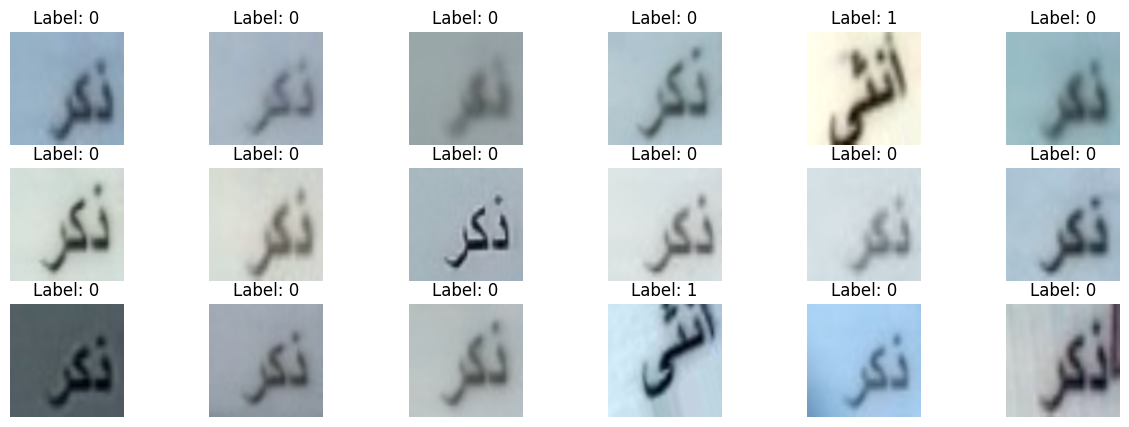

In [5]:
train_dataset = tf.data.Dataset.from_tensor_slices((train_images, train_labels)).batch(32)  # Adjust batch size as needed
val_dataset = tf.data.Dataset.from_tensor_slices((val_images, val_labels)).batch(32)

def plot_images_from_dataset(dataset, num_images=18):
    # Take a batch from the dataset
    for images, labels in dataset.take(1):  # Take one batch
        n = min(num_images, images.shape[0])  # Number of images to plot
        plt.figure(figsize=(15, 5))  # Adjust size for images
        for i in range(n):
            plt.subplot(3, 6, i + 1)  # Create a grid for the images
            plt.imshow(images[i].numpy())  # Convert tensor to numpy for plotting
            plt.title(f'Label: {labels[i].numpy()}')  # Show the label
            plt.axis('off')  # Hide axes
        plt.show()

# Plot 18 images from the train dataset
plot_images_from_dataset(train_dataset, num_images=18)


### Baseline Model: Simplle CNN 

In [6]:
def baseline_model(input_shape):
    X_input = Input(input_shape)
    
    X = ZeroPadding2D((3, 3))(X_input)
    
    X = Conv2D(32, (5, 5), strides=(1, 1))(X)
    X = BatchNormalization(axis=3)(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((2, 2))(X)
    X = Flatten()(X)    
    X = Dropout(0.5)(X) 
    X = Dense(1, activation='sigmoid')(X)

    model = Model(inputs=X_input, outputs=X, name='GenderClassification')    
    return model

In [7]:
input_shape = train_images.shape[1:]
gender_model = baseline_model(input_shape)
gender_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
gender_model.summary()

Model: "GenderClassification"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ zero_padding2d (ZeroPadding2D)  │ (None, 230, 230, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 226, 226, 32)   │         2,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 226, 226, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 226, 226, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 113, 113, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 408608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 408608)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │       408,609 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 411,169 (1.57 MB)

 Trainable params: 411,105 (1.57 MB)

 Non-trainable params: 64 (256.00 B)

### Training

In [13]:
class_weight_dict = {0: 1.0, 1: 5.0}
history = gender_model.fit(train_dataset, validation_data=val_dataset, epochs=20, class_weight=class_weight_dict)
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

Epoch 1/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 814ms/step - accuracy: 0.9861 - loss: 2.8308 - val_accuracy: 0.7209 - val_loss: 25.9508
Epoch 2/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 986ms/step - accuracy: 0.9827 - loss: 0.5089 - val_accuracy: 0.4718 - val_loss: 67.9958
Epoch 3/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 22s 1s/step - accuracy: 0.9860 - loss: 0.2604 - val_accuracy: 0.8272 - val_loss: 14.5916
Epoch 4/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 914ms/step - accuracy: 0.9953 - loss: 0.0410 - val_accuracy: 0.9336 - val_loss: 5.3740
Epoch 5/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 20s 910ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.9635 - val_loss: 2.5211
Epoch 6/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 19s 857ms/step - accuracy: 1.0000 - loss: 4.1552e-07 - val_accuracy: 0.9701 - val_loss: 1.5818
Epoch 7/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 817ms/step - accuracy: 1.0000 - loss: 5.0177e-06 - val_accuracy: 0.9767 - val_loss: 1.0829
Epoch 8/20
22/22 ━━━━━━━━━━━━━━━━━━━━ 18s 797ms/step - accuracy: 1.0000 - loss: 1.4627e-0

### Evaluation Plot (val vs train)

Training Accuracy: 1.0
Validation Accuracy: 0.9966777563095093


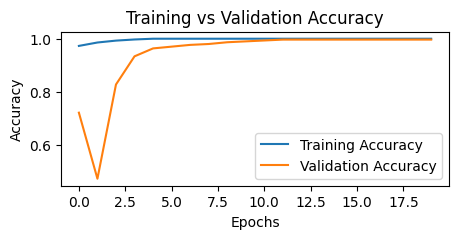

In [14]:
training_accuracy = history.history['accuracy']
validation_accuracy = history.history['val_accuracy']

print("Training Accuracy:", training_accuracy[-1])  
print("Validation Accuracy:", validation_accuracy[-1]) 

# Plotting training and validation accuracy
plt.figure(figsize=(5, 2))
plt.plot(training_accuracy, label='Training Accuracy')
plt.plot(validation_accuracy, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()




### Final Eval

In [15]:
val_predictions_prob = gender_model.predict(val_images)  
val_predictions = (val_predictions_prob > 0.5).astype(int) 

# Step 2: Calculate F1 score
f1 = f1_score(val_labels, val_predictions)
tn, fp, fn, tp = confusion_matrix(val_labels, val_predictions).ravel()

print("True Negatives (TN):", tn)
print("False Positives (FP) *:", fp)
print("False Negatives (FN) *:", fn)
print("True Positives (TP):", tp)

#print("FN/FP Ratio:", fn / fp if fp != 0 else 'Inf')  
print("f1-score: ", f1)



10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 127ms/step
True Negatives (TN): 251
False Positives (FP) *: 0
False Negatives (FN) *: 1
True Positives (TP): 49
f1-score:  0.98989898989899


### Save model & weights

In [ ]:
#gender_model.save('gender_model.keras')
#gender_model.save_weights('gender_model.weights.h5')

In [ ]:
# m/f class weight ratio = 1:30
# no dropout
#20 epoch
# aug applied
#fn: 0 fp:1

In [ ]:
# inc female class from 3% to 23% by augmentations
